# **Data Preprocessing: Stage Two**

1.	Splitting the training data (windowed under sampling):
-	Get the durations for all the species
-	From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training
-	The remaining samples will be the validation data
-	Normalize the audio samples
-	Turn all the data into windowed Mel-spectrograms (window the audio using half overlap and normalization of spectrograms)
-	Since the audio samples are the same duration, the dimensions of the Mel will be the same
-	(Save that into a pkl file or something for easy access for all the models)



I noticed that the volumes of the samples where very different. 
* I will try first normalizing the volume of all samples between 0 and 1. 
* Then i will convert those to mel spectrograms, and then normalize those between 0 and 1 also between sample

I noticed that the lengths are very different so scaling it by stretching and shrinking the data basically gave the machine nonsense and thats why the accuracy was bad. 

I can try using audio samples that are greater than 2 seconds long, and use a 2 second window and a 1 second overlap to create the spectrograms with each sample, keeping track of the class of the audio sample. This should make all the spectrograms have the same size and surely improve the results a bit. 

I will experiment with different window sizes and save those files in pkl for later. 

* I will do 2 sec with 1 sec overlap
* I will do 4 sec with 2 sec overlap
* I will do 6 sec with 3 sec overlap
* I will do 8 sec with 4 sec overlap

This is just to show how one improvement (overlap) can affect results

### I am going to pad the audio samples with less duration with pink noise. Pink noise is much better than white noise as it sounds more natural

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import IPython.display as ipd

# Feature Extraction

Turning the data into windowed Mel-spectrograms 

In [3]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/'  # Where to save Mel spectrograms
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-2-trainval.csv'
n_mels = 128
target_shape = (128,128)
sr = 16000

In [4]:
# Loading the train-validation split CSV
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [47]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/Padded/padded_train_mel_spectrograms-6s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/Padded/padded_val_mel_spectrograms-6s.pkl'

In [6]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [17]:
def generate_pink_noise(num_samples):
    white_noise = np.random.randn(num_samples)
    
    # Apply a filter to convert white noise into pink noise (1/f noise)
    X = np.fft.rfft(white_noise)
    S = np.arange(1, len(X) + 1)  # Frequency scaling
    pink_noise = np.fft.irfft(X / S)
    
    return normalize_audio(pink_noise)

In [19]:
# Proving why pink noise is a better choise than white noise
npy_file = "tafpri1/XC363881.npy"
audio_data = np.load(npy_path + npy_file)
num_samples = sr * 10
pink_noise = generate_pink_noise(num_samples)
gaussian_noise = np.random.normal(0, 0.005, num_samples)
audio_data_normalized = normalize_audio(audio_data)
gaussian_noise_normalized = normalize_audio(gaussian_noise)

audio_data_wnoise = normalize_audio(np.concatenate([audio_data_normalized, pink_noise]))
ipd.Audio(audio_data_wnoise, rate=sr)

In [26]:
# Function to pad audio with noise
def pad_with_noise(audio_data, window_length, sr=sr):
    current_length = librosa.get_duration(y=audio_data, sr=sr)
    if current_length >= window_length:
        return audio_data
    
    target_length_samples = int(window_length * sr)
    current_length_samples = len(audio_data)
    padding_length_samples = target_length_samples - current_length_samples
    
    # Generate pink noise to pad with
    pink_noise = generate_pink_noise(padding_length_samples)
    padded_audio = np.concatenate([audio_data, pink_noise])
    
    return padded_audio

In [48]:
# Function to generate mel spectrogram with sliding window and overlap
def get_mel_spectrogram_with_window(npy_file, sr=sr, n_mels=128, hop_length=512, window_size=6, overlap=3, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    # audio_duration = librosa.get_duration(y=audio_data, sr=sr)  
    audio_data = normalize_audio(audio_data)
    audio_data = pad_with_noise(audio_data, window_length=window_size)
    
    # Define the step based on the window and overlap (in samples, not time)
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    mel_spectrograms = []
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
        
        # Resize the mel spectrogram to 128x128
        mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                          target_shape[1] / mel_spectrogram_db.shape[1]))
        mel_spectrograms.append(mel_spectrogram_resized)
    
    return mel_spectrograms

In [49]:
# Function to generate and organize Mel spectrograms in a dictionary
def prepare_data_for_model_dict(npy_files, labels, sr=sr, window_size=6, overlap=3, target_shape=(128, 128)):
    mel_spectrograms_dict = {}

    for npy_file, label in zip(npy_files, labels):
        mel_specs = get_mel_spectrogram_with_window(npy_file, sr=sr, window_size=window_size, overlap=overlap, target_shape=target_shape)
        if mel_specs is None:
            continue  # Skip short files
        
        for i, mel_spec in enumerate(mel_specs):
            mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add a channel dimension for CNN
            key = f"{npy_file}_window_{i}"  # Create a unique key for each windowed spectrogram
            mel_spectrograms_dict[key] = (mel_spec, label)

    return mel_spectrograms_dict


## Processing the training data

In [50]:
train_mel_spectrograms = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training Mel spectrograms", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    mel_spec_dict = prepare_data_for_model_dict([npy_file], [label])  # Pass as lists to match function signature
    
    # Store each windowed Mel spectrogram with its respective label
    for key, value in mel_spec_dict.items():
        train_mel_spectrograms[key] = value  # key is the windowed filename, value is (mel_spectrogram, label)


Processing training Mel spectrograms: 100%|██████████| 933/933 [05:24<00:00,  2.87it/s]


In [51]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_mel_spectrograms, f)

## Processing the validation data

In [52]:
val_mel_spectrograms = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing training Mel spectrograms", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate Mel spectrograms with windowing (this will return a dictionary of multiple windows)
    mel_spec_dict = prepare_data_for_model_dict([npy_file], [label])  # Pass as lists to match function signature
    
    # Store each windowed Mel spectrogram with its respective label
    for key, value in mel_spec_dict.items():
        val_mel_spectrograms[key] = value  # key is the windowed filename, value is (mel_spectrogram, label)


Processing training Mel spectrograms: 100%|██████████| 1824/1824 [14:42<00:00,  2.07it/s] 


In [53]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_mel_spectrograms, f)

In [54]:
del f

## Plotting the spectrograms

In [59]:
def view_mel_spectrogram_by_index(train_mel_spectrograms, index, isTrain=True):
    # Get the key for the chosen index
    key = list(train_mel_spectrograms.keys())[index]
    
    # temp_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'
    

    
    # Extract mel spectrogram and label from the dictionary
    mel_spectrogram, label = train_mel_spectrograms[key]
    
    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram.squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram for {label} (Index: {index})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

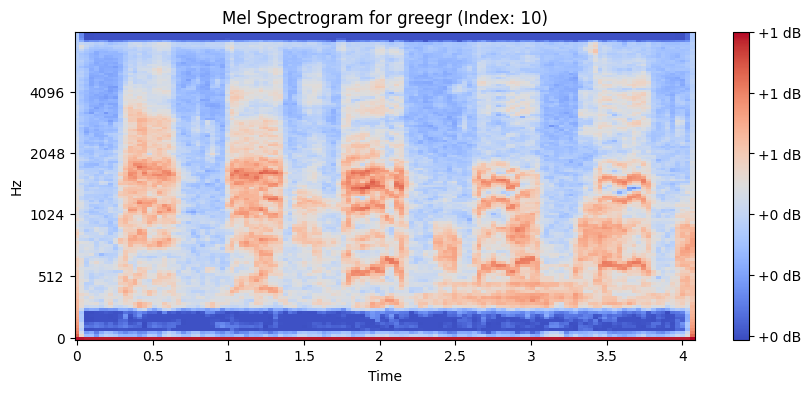

In [60]:
view_mel_spectrogram_by_index(train_mel_spectrograms, 10)

# Confirming that the pickle files were saved correctly:

In [56]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms_2 = pickle.load(f)

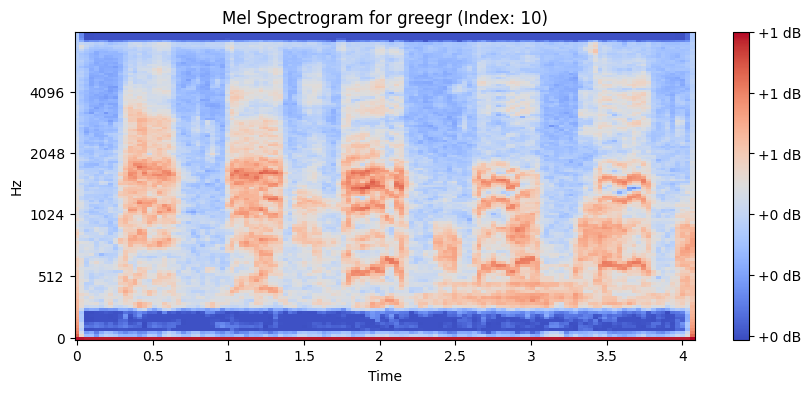

In [58]:
view_mel_spectrogram_by_index(train_mel_spectrograms_2, 10)